In [1]:
%load_ext rpy2.ipython
import warnings
warnings.filterwarnings('ignore')

# How many stocks to select?
We want to get some more insight into the data we produced with our Hypercube job. Thus, we first read the scalar data and transform it into a single large dataframe:

In [2]:
%%R
library(tidyr)
library(dplyr)
library(readr)
library(ggplot2)
library(gridExtra)
library(knitr)

filesToRead <- c("scalars.csv", "scalars_out.csv")
scenScalars <- bind_rows(lapply(list.dirs("data")[-1], function(scen){
  filePaths <- file.path(scen, filesToRead)
  bind_rows(lapply(filePaths, read_csv, 
                   col_types = cols()))[c(1,3)] %>%
    spread(scalar, value, convert = TRUE)
})) %>%
  mutate(error_train_norm = error_train/trainingdays, 
         error_test_norm = error_test/(252 - trainingdays),
         error_ratio_norm = error_ratio/trainingdays) %>%
  mutate(maxstock = as.factor(maxstock), 
         trainingdays = as.factor(trainingdays))
kable(head(scenScalars), caption = "Raw scalar data")



| error_ratio| error_test| error_train|lastdaytraining |maxstock |mip  |trainingdays | error_train_norm| error_test_norm| error_ratio_norm|
|-----------:|----------:|-----------:|:---------------|:--------|:----|:------------|----------------:|---------------:|----------------:|
|   27.894663|   26.11184|   0.9360871|2016-05-24      |23       |SCIP |99           |        0.0094554|       0.1706656|        0.2817643|
|   12.118973|   26.06389|   2.1506685|2016-07-07      |22       |SCIP |129          |        0.0166718|       0.2119016|        0.0939455|
|    7.109752|  249.03047|  35.0266060|2016-07-07      |5        |SCIP |129          |        0.2715241|       2.0246380|        0.0551144|
|  172.617428|   63.00389|   0.3649915|2016-02-29      |21       |SCIP |39           |        0.0093588|       0.2957929|        4.4260879|
|    4.166327|  125.21678|  30.0544814|2016-08-18      |7        |SCIP |159          |        0.1890219|       1.3464170|        0.0262033|
|    8.283518|  11

Now that we have the data in the shape we want, we can plot it. Let's first look at the training error:

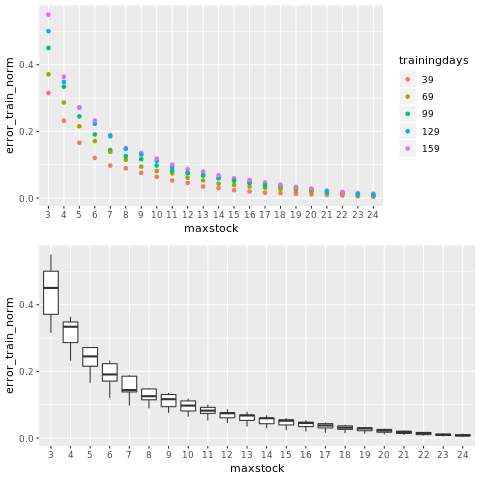

In [3]:
%%R
p1 <- ggplot(scenScalars, aes(maxstock, error_train_norm))
grid.arrange(p1 + geom_point(aes(color = trainingdays)), 
             p1 + geom_boxplot())

This result is not very surprising: The more stocks we allow the model to select, the less training error we get. Additionally, if we increase the number of training days, the error increases as we have more data to approximate. 
Let's now look at the error in the test phase:

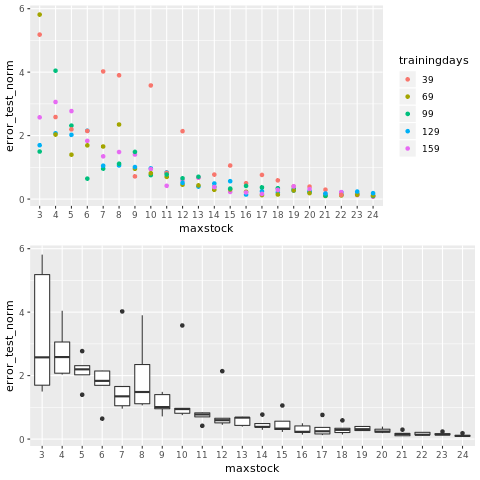

In [4]:
%%R
p2 <- ggplot(scenScalars, aes(maxstock, error_test_norm))
grid.arrange(p2 + geom_point(aes(color = trainingdays)), 
             p2 + geom_boxplot())

The results here are not so clear as before. Again, we observe that the error as well as the variance decreases with an increasing number of stocks we are allowed to select. However, with just 12 stocks to select, we already achieve quite low test errors together with a low variance. 

By plotting the ratio $\frac{error_{test}}{error_{train}}$, we might find out some more about this "sweet spot".

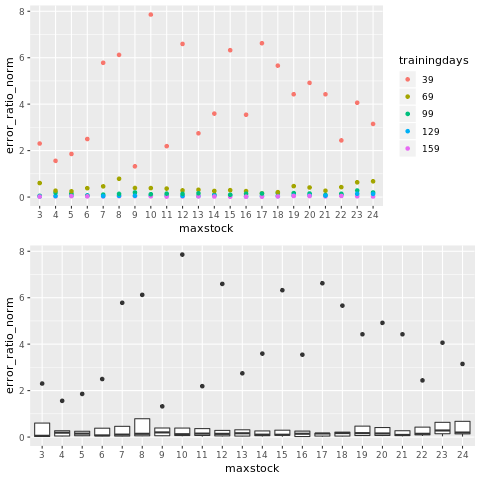

In [5]:
%%R
p3 <- ggplot(scenScalars, aes(maxstock, error_ratio_norm))
grid.arrange(p3 + geom_point(aes(color = trainingdays)), 
             p3 + geom_boxplot())

And in fact, this provides more insight: 39 training days definitely seem to be too little to get right results. The error in the test phase is very large w.r.t the training phase. If we train the model with 30 additional days, the error ratio drastically decreases! Let's throw away these data points and plot again:

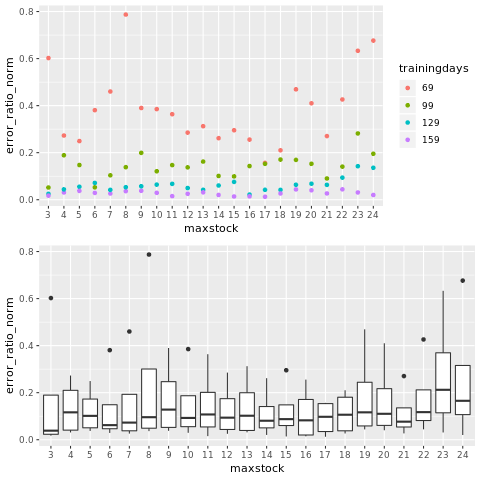

In [6]:
%%R
scenScalars_clean <- scenScalars %>% filter(!trainingdays %in% 39)
p4 <- ggplot(scenScalars_clean, aes(maxstock, error_ratio_norm))
grid.arrange(p4 + geom_point(aes(color = trainingdays)), 
             p4 + geom_boxplot())

The results don't seem very clear. However, one thing to note that might be counterintuitive is that we definitely don't get better results the more stocks we select. This effect is referred to as [under/overfitting](https://en.wikipedia.org/wiki/Overfitting). The sweet spot seems to be somwhere in the middle of this interval (14-15 stocks).
Let's now look at the sum of training and testing error instead. This KPI supports the observation that with just 14-15 stocks we already get results that are almost as good as if we would allow 24 stocks to be selected.

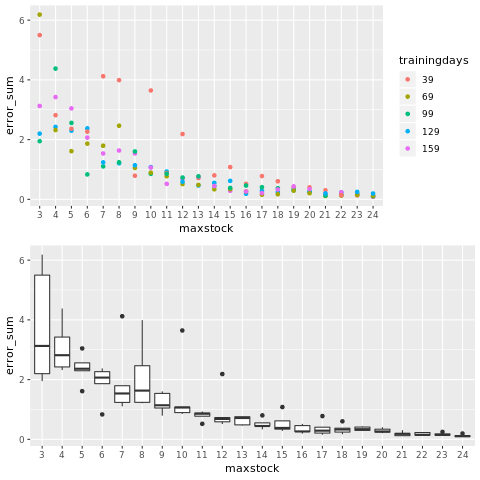

In [7]:
%%R
scenScalars_errsum <- scenScalars %>% 
  mutate(error_sum = error_train_norm + error_test_norm)
p5 <- ggplot(scenScalars_errsum, aes(maxstock, error_sum))
grid.arrange(p5 + geom_point(aes(color = trainingdays)), 
             p5 + geom_boxplot())

# How many training days to choose?
The other parameter that is interesting to the planner is how many days to train the model with. We previously observed that 39 training days seem way too little and just 30 more days already reduce the error ratio by a large amount. Let's take a closer look at this effect:

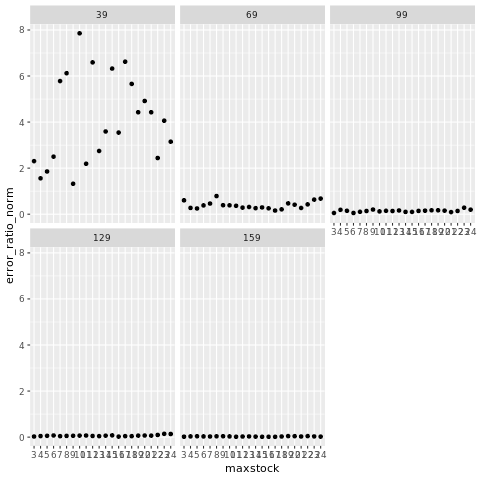

In [8]:
%%R
p3 + geom_point() + facet_wrap(~ trainingdays, nrow=2)

In general, the error ratio decreases with the number of training days. The interval between 39 and 69 training days seems interesting if you want to answer the question of how many training days you should use at minimum. Let's investigate this interval more closely by submitting another *Hypercube job*. We import these results and plot the results:

In [9]:
%%R
filesToRead <- c("scalars.csv", "scalars_out.csv")
scenScalars_td <- bind_rows(lapply(list.dirs("data2")[-1], function(scen){
  filePaths <- file.path(scen, filesToRead)
  bind_rows(lapply(filePaths, read_csv, col_types = cols()))[c(1,3)] %>%
    spread(scalar, value, convert = TRUE)
})) %>%
  mutate(maxstock = as.factor(maxstock), 
         trainingdays = as.factor(trainingdays)) 
kable(head(scenScalars_td), caption = "Scalars in interval between 44 to 89 trainingdays")



| error_ratio| error_test| error_train|lastdaytraining |maxstock |mip  |trainingdays |
|-----------:|----------:|-----------:|:---------------|:--------|:----|:------------|
|   187.90132|  307.25740|    1.635206|2016-03-14      |15       |SCIP |49           |
|    52.04262| 1061.75620|   20.401669|2016-03-29      |3        |SCIP |59           |
|   117.46332|  148.68864|    1.265830|2016-03-07      |15       |SCIP |44           |
|    28.63041|   61.23493|    2.138807|2016-03-29      |15       |SCIP |59           |
|    20.15562|   49.21501|    2.441752|2016-04-05      |15       |SCIP |64           |
|    26.90599|  174.92183|    6.501223|2016-04-12      |9        |SCIP |69           |


We plot the results of this run as well:

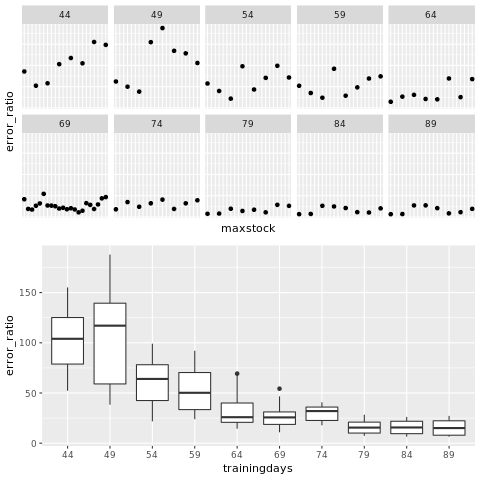

In [10]:
%%R
p4 <- ggplot(scenScalars_td, aes(maxstock, error_ratio)) + 
  geom_point() + facet_wrap(~ trainingdays, nrow=2) + 
  theme(axis.text.x = element_blank(),
        axis.text.y = element_blank(),
        axis.ticks = element_blank())
p5 <- ggplot(scenScalars_td, aes(trainingdays, error_ratio)) + 
  geom_boxplot()
grid.arrange(p4, p5)

It looks like we should choose atleast 64 training days. Much less than that results in big error ratios as well as a lot of sensitivity.